### Importing useful packages

In [131]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as tick
import matplotlib.dates as mdates
import numpy as np
import time
import seaborn as sns
import math
from datetime import timedelta, date
from sklearn import preprocessing

### Creating data frames for weeks ending June 6th through June 27th (four weeks)

In [99]:
week1_url = 'http://web.mta.info/developers/data/nyct/turnstile/turnstile_200606.txt'
week2_url = 'http://web.mta.info/developers/data/nyct/turnstile/turnstile_200613.txt'
week3_url = 'http://web.mta.info/developers/data/nyct/turnstile/turnstile_200620.txt'
week4_url = 'http://web.mta.info/developers/data/nyct/turnstile/turnstile_200627.txt'

col_name = ['C/A', 'Unit', 'SCP', 'Station', 'Line Name', 
            'Division', 'Date', 'Time', 'Description', 'Entries', 'Exits']

week1 = pd.read_csv(week1_url, sep=",", header=0, names = col_name)
week2 = pd.read_csv(week2_url, sep=",", header=0, names = col_name)
week3 = pd.read_csv(week3_url, sep=",", header=0, names = col_name)
week4 = pd.read_csv(week4_url, sep=",", header=0, names = col_name)


### Combining all 4 weeks' data into one file

In [100]:
filelist = [week1, week2, week3, week4]
mta_df = pd.concat(filelist, axis=0, ignore_index=True)

### Displaying the 4 weeks' data (first and last few rows)

In [101]:
mta_df.head()

,C/A,Unit,SCP,Station,Line Name,Division,Date,Time,Description,Entries,Exits
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/30/2020,00:00:00,REGULAR,7419887,2520505
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/30/2020,04:00:00,REGULAR,7419888,2520505
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/30/2020,08:00:00,REGULAR,7419895,2520514
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/30/2020,12:00:00,REGULAR,7419911,2520531
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/30/2020,16:00:00,REGULAR,7419940,2520553


In [102]:
mta_df.tail()

,C/A,Unit,SCP,Station,Line Name,Division,Date,Time,Description,Entries,Exits
827959,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,06/26/2020,05:00:00,REGULAR,5554,514
827960,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,06/26/2020,09:00:00,REGULAR,5554,514
827961,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,06/26/2020,13:00:00,REGULAR,5554,514
827962,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,06/26/2020,17:00:00,REGULAR,5554,514
827963,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,06/26/2020,21:00:00,REGULAR,5554,514


### Calculate net entry & net exit for each turnstile

In [103]:
# date or time is not unique, but date_time is
mta_df['date_time'] = mta_df.Date + ' ' + mta_df.Time
mta_df.date_time = pd.to_datetime(mta_df.date_time)

# get the time difference between this row and next row
# it is supposed to be 4-hour
mta_df['next_date_time'] = mta_df.date_time.shift(-1)
mta_df['time_diff'] = mta_df.next_date_time - mta_df.date_time
mta_df.time_diff = mta_df.time_diff.apply(lambda x: x.total_seconds())
mta_df.time_diff = mta_df.time_diff / 14400

# get the entry & exit reading in the next row
mta_df['next_entry'] = mta_df.Entries.shift(-1)
mta_df['next_exit'] = mta_df.Exits.shift(-1)

# take the difference to calculate the net entry & net exit
mta_df['net_entry'] = mta_df.next_entry - mta_df.Entries
mta_df['net_exit'] = mta_df.next_exit - mta_df.Exits

mta_df = mta_df[['SCP', 'Station', 'Line Name', 'Division',
             'Date', 'Time', 'time_diff', 'net_entry', 'net_exit']]
mta_df = mta_df.dropna()

# make sure the difference is taken on two consecutive readings
mta_df = mta_df[mta_df.time_diff == 1.0] 

mta_df = mta_df.reset_index(drop = True)
mta_df.head()

,SCP,Station,Line Name,Division,Date,Time,time_diff,net_entry,net_exit
0,02-00-00,59 ST,NQR456W,BMT,05/30/2020,00:00:00,1.0,1.0,0.0
1,02-00-00,59 ST,NQR456W,BMT,05/30/2020,04:00:00,1.0,7.0,9.0
2,02-00-00,59 ST,NQR456W,BMT,05/30/2020,08:00:00,1.0,16.0,17.0
3,02-00-00,59 ST,NQR456W,BMT,05/30/2020,12:00:00,1.0,29.0,22.0
4,02-00-00,59 ST,NQR456W,BMT,05/30/2020,16:00:00,1.0,37.0,8.0


In [104]:
mta_df.tail()

,SCP,Station,Line Name,Division,Date,Time,time_diff,net_entry,net_exit
751108,00-05-01,RIT-ROOSEVELT,R,RIT,06/26/2020,01:00:00,1.0,0.0,0.0
751109,00-05-01,RIT-ROOSEVELT,R,RIT,06/26/2020,05:00:00,1.0,0.0,0.0
751110,00-05-01,RIT-ROOSEVELT,R,RIT,06/26/2020,09:00:00,1.0,0.0,0.0
751111,00-05-01,RIT-ROOSEVELT,R,RIT,06/26/2020,13:00:00,1.0,0.0,0.0
751112,00-05-01,RIT-ROOSEVELT,R,RIT,06/26/2020,17:00:00,1.0,0.0,0.0


### Calculating Net Traffic where Net Traffic = Net Entries + Net Exits

In [105]:
mta_df['net_traffic'] = mta_df.net_entry + mta_df.net_exit

mta_df = mta_df[['SCP', 'Station', 'Line Name', 'Division',
             'Date', 'Time', 'time_diff', 'net_entry', 'net_exit', 'net_traffic']]

mta_df.head()

,SCP,Station,Line Name,Division,Date,Time,time_diff,net_entry,net_exit,net_traffic
0,02-00-00,59 ST,NQR456W,BMT,05/30/2020,00:00:00,1.0,1.0,0.0,1.0
1,02-00-00,59 ST,NQR456W,BMT,05/30/2020,04:00:00,1.0,7.0,9.0,16.0
2,02-00-00,59 ST,NQR456W,BMT,05/30/2020,08:00:00,1.0,16.0,17.0,33.0
3,02-00-00,59 ST,NQR456W,BMT,05/30/2020,12:00:00,1.0,29.0,22.0,51.0
4,02-00-00,59 ST,NQR456W,BMT,05/30/2020,16:00:00,1.0,37.0,8.0,45.0


In [106]:
mta_df.tail()

,SCP,Station,Line Name,Division,Date,Time,time_diff,net_entry,net_exit,net_traffic
751108,00-05-01,RIT-ROOSEVELT,R,RIT,06/26/2020,01:00:00,1.0,0.0,0.0,0.0
751109,00-05-01,RIT-ROOSEVELT,R,RIT,06/26/2020,05:00:00,1.0,0.0,0.0,0.0
751110,00-05-01,RIT-ROOSEVELT,R,RIT,06/26/2020,09:00:00,1.0,0.0,0.0,0.0
751111,00-05-01,RIT-ROOSEVELT,R,RIT,06/26/2020,13:00:00,1.0,0.0,0.0,0.0
751112,00-05-01,RIT-ROOSEVELT,R,RIT,06/26/2020,17:00:00,1.0,0.0,0.0,0.0


### Visualizing data to spot outliers

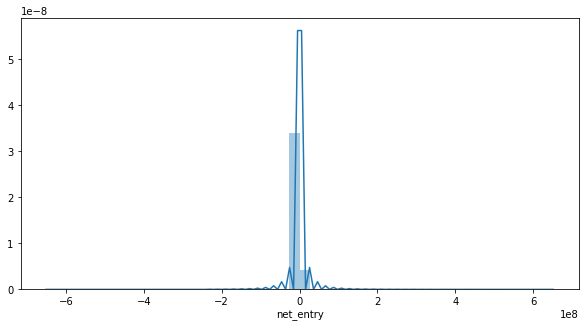

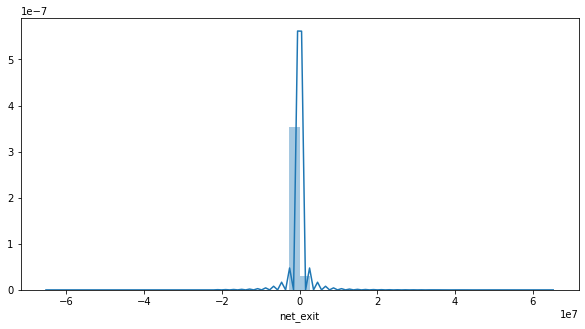

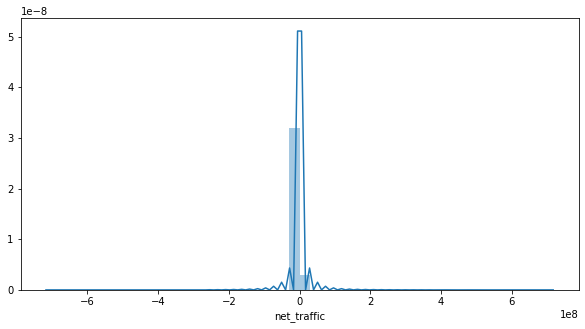

In [107]:
fig, ax = plt.subplots(ncols=1, figsize=(10,5))
sns.distplot(mta_df.net_entry)

fig, ax = plt.subplots(ncols=1, figsize=(10,5))
sns.distplot(mta_df.net_exit)

fig, ax = plt.subplots(ncols=1, figsize=(10,5))
sns.distplot(mta_df.net_traffic);

In [108]:
mta_df = mta_df[(mta_df.net_traffic > 0) & (mta_df.net_traffic < 200000)]

In [109]:
mta_df.loc[mta_df['net_traffic'].idxmin()]

SCP              02-00-00
Station             59 ST
Line Name         NQR456W
Division              BMT
Date           05/30/2020
Time             00:00:00
time_diff               1
net_entry               1
net_exit                0
net_traffic             1
Name: 0, dtype: object

In [110]:
mta_df.loc[mta_df['net_traffic'].idxmax()]

SCP                   01-00-01
Station        WORLD TRADE CTR
Line Name                ACE23
Division                   IND
Date                06/19/2020
Time                  08:00:00
time_diff                    1
net_entry                16399
net_exit                    96
net_traffic              16495
Name: 434339, dtype: object

### Adding Day of the Week to the dataframe

In [111]:
mta_df['Weekday'] = pd.to_datetime(mta_df.Date).dt.day_name()

In [112]:
mta_df.head()

,SCP,Station,Line Name,Division,Date,Time,time_diff,net_entry,net_exit,net_traffic,Weekday
0,02-00-00,59 ST,NQR456W,BMT,05/30/2020,00:00:00,1.0,1.0,0.0,1.0,Saturday
1,02-00-00,59 ST,NQR456W,BMT,05/30/2020,04:00:00,1.0,7.0,9.0,16.0,Saturday
2,02-00-00,59 ST,NQR456W,BMT,05/30/2020,08:00:00,1.0,16.0,17.0,33.0,Saturday
3,02-00-00,59 ST,NQR456W,BMT,05/30/2020,12:00:00,1.0,29.0,22.0,51.0,Saturday
4,02-00-00,59 ST,NQR456W,BMT,05/30/2020,16:00:00,1.0,37.0,8.0,45.0,Saturday


In [113]:
mta_df.tail()

,SCP,Station,Line Name,Division,Date,Time,time_diff,net_entry,net_exit,net_traffic,Weekday
750944,00-00-01,RIT-ROOSEVELT,R,RIT,06/26/2020,01:00:00,1.0,0.0,1.0,1.0,Friday
750945,00-00-01,RIT-ROOSEVELT,R,RIT,06/26/2020,05:00:00,1.0,135.0,1.0,136.0,Friday
750946,00-00-01,RIT-ROOSEVELT,R,RIT,06/26/2020,09:00:00,1.0,167.0,4.0,171.0,Friday
750947,00-00-01,RIT-ROOSEVELT,R,RIT,06/26/2020,13:00:00,1.0,172.0,1.0,173.0,Friday
750948,00-00-01,RIT-ROOSEVELT,R,RIT,06/26/2020,17:00:00,1.0,152.0,4.0,156.0,Friday


### Aggregating net_traffic by station, day of the week and time of day

In [115]:
mta_df = mta_df.groupby(['Station','Weekday', 'Time']).sum()['net_traffic'].reset_index()

In [116]:
mta_df.head()

,Station,Weekday,Time,net_traffic
0,1 AV,Friday,00:00:00,471.0
1,1 AV,Friday,04:00:00,5261.0
2,1 AV,Friday,08:00:00,6946.0
3,1 AV,Friday,12:00:00,7676.0
4,1 AV,Friday,16:00:00,8282.0


In [117]:
mta_df.tail()

,Station,Weekday,Time,net_traffic
16339,ZEREGA AV,Wednesday,05:00:00,1542.0
16340,ZEREGA AV,Wednesday,09:00:00,829.0
16341,ZEREGA AV,Wednesday,13:00:00,1150.0
16342,ZEREGA AV,Wednesday,17:00:00,1097.0
16343,ZEREGA AV,Wednesday,21:00:00,342.0


### The net_traffic column adds up all the traffic from the 4 weeks. We must divide the values by 4 to get a per week average

In [118]:
mta_df['net_traffic_avg'] = mta_df.net_traffic/4

In [119]:
mta_df.head()

,Station,Weekday,Time,net_traffic,net_traffic_avg
0,1 AV,Friday,00:00:00,471.0,117.75
1,1 AV,Friday,04:00:00,5261.0,1315.25
2,1 AV,Friday,08:00:00,6946.0,1736.50
3,1 AV,Friday,12:00:00,7676.0,1919.00
4,1 AV,Friday,16:00:00,8282.0,2070.50


In [120]:
mta_df.tail()

,Station,Weekday,Time,net_traffic,net_traffic_avg
16339,ZEREGA AV,Wednesday,05:00:00,1542.0,385.50
16340,ZEREGA AV,Wednesday,09:00:00,829.0,207.25
16341,ZEREGA AV,Wednesday,13:00:00,1150.0,287.50
16342,ZEREGA AV,Wednesday,17:00:00,1097.0,274.25
16343,ZEREGA AV,Wednesday,21:00:00,342.0,85.50


### Now we will normalize the net_traffic_avg to a scale of 1 to 10

In [123]:
mta_df.loc[mta_df['net_traffic_avg'].idxmin()]

Station            AVENUE I
Weekday            Saturday
Time               01:00:00
net_traffic               1
net_traffic_avg        0.25
Name: 5874, dtype: object

In [124]:
mta_df.loc[mta_df['net_traffic_avg'].idxmax()]

Station            14 ST-UNION SQ
Weekday                    Friday
Time                     13:00:00
net_traffic                 35697
net_traffic_avg           8924.25
Name: 741, dtype: object

In [133]:
a, b = 1, 10
x, y = mta_df.net_traffic_avg.min(), mta_df.net_traffic_avg.max()
mta_df['normalized_traffic'] = (mta_df.net_traffic_avg - x) / (y - x) * (b - a) + a

In [134]:
mta_df.head()

,Station,Weekday,Time,net_traffic,net_traffic_avg,normalized_traffic
0,1 AV,Friday,00:00:00,471.0,117.75,1.118501
1,1 AV,Friday,04:00:00,5261.0,1315.25,2.326199
2,1 AV,Friday,08:00:00,6946.0,1736.50,2.751037
3,1 AV,Friday,12:00:00,7676.0,1919.00,2.935091
4,1 AV,Friday,16:00:00,8282.0,2070.50,3.087881


In [135]:
mta_df.tail()

,Station,Weekday,Time,net_traffic,net_traffic_avg,normalized_traffic
16339,ZEREGA AV,Wednesday,05:00:00,1542.0,385.50,1.388531
16340,ZEREGA AV,Wednesday,09:00:00,829.0,207.25,1.208763
16341,ZEREGA AV,Wednesday,13:00:00,1150.0,287.50,1.289696
16342,ZEREGA AV,Wednesday,17:00:00,1097.0,274.25,1.276333
16343,ZEREGA AV,Wednesday,21:00:00,342.0,85.50,1.085976


In [136]:
import os
cwd = os.getcwd()
print(cwd)

E:\Mass Transit\MTA Turnstile Data


In [139]:
mta_df.to_csv("normalized_traffic_data.csv")